In [1]:
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

In [19]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [20]:
# loads all data sets into a dict
def load_datasets(dirs: list, load_path: str) -> dict:
    files = ['soil_c','surf_water','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','plant_stress','photosynthesis','plant_growth']
    
    #files.append('soil_temp', 'canopy_temp') missing 
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = 'datasets/' + dr + load_path
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

In [21]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df


mdays=[31,28,31,30,31,30,31,31,30,31,30,31]

def isleap(year):
    leap=False
    if year % 4 == 0 and year % 100 != 0:
        leap=True
    elif year % 100 == 0:
        leap=False
    elif year % 400 ==0:
        leap=True
    else:
        leap=False
    return leap
def dayofyear(year,month,day):
    doy=0
    for mm in range(0,month):
        days=mdays[mm]
        if mm==1:
            if isleap(year):
                days=29
        for dd in range(0,days):
            if mm < month-1:
                doy=doy+1
            else:
                if dd < day:
                    doy=doy+1
    return doy

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

def nee_cumulative_to_daily(df: pd.DataFrame) -> pd.DataFrame:
    df['DOY'] = df['DOY'].astype(int)

    # Divide only rows with DOY > 0
    df['ECO_NPP'] = df.apply(lambda row: row['ECO_NPP']/row['DOY'] if row['DOY'] != 0 else row['ECO_NPP'], axis=1)
    df['ECO_RH'] = df.apply(lambda row: row['ECO_RH']/row['DOY'] if row['DOY'] != 0 else row['ECO_RH'], axis=1)

    df['NEE'] = df['ECO_NPP'] - df['ECO_RH']
    
    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)
    
    x['WIND'] = x['WIND'] / 100
    
    x['DATE'] =  pd.to_datetime(x['DATE'])
    
    x['DOY'] = 0
    for i in range( x.shape[0]):
        x['DOY'][i] = dayofyear(x['DATE'][i].year, x['DATE'][i].month, x['DATE'][i].day)
    

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True))
df_irr = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True))
df_cool = nee_cumulative_to_daily(to_pd(datasets['cool_temp_maize_soybean'], True, True))

df = pd.concat([df_dry,df_irr, df_cool])

y = df[target].copy()

#y = df[target].copy()
#df = df.drop(target, axis=1)

## AmeriFLUX USNE Dataset irrigated maize-soybean, years 2015- 2021

### NEE with constant ustar threshold, found by k means 

In [22]:
observed_df = pd.read_csv('datasets/extractedNEE_CUT_REF_NIGHT_Final'  + '.csv')

In [23]:
observed_df

,Unnamed: 0,DATE,DOY,HMAX_AIR,TMIN_AIR,TMAX_SOIL,HMIN_AIR,TMAX_AIR,RADN,WIND,D_W_PRECN,TMIN_SOIL,NEE
0,0,2015-01-01,1,0.630569,-8.316,2.026,0.435766,-6.186,152.441,2.543,0.000,3.167734,0.728700
1,1,2015-01-02,2,0.630147,-6.127,2.148,0.349557,-5.299,153.067,1.614,0.000,2.970467,0.756333
2,2,2015-01-03,3,0.796492,-7.555,2.010,0.324438,-6.735,153.753,3.187,1.559,2.820677,0.717230
3,3,2015-01-04,4,0.897199,-14.733,1.373,0.501948,-15.570,154.497,4.039,1.094,3.144463,0.684707
4,4,2015-01-05,5,0.702206,-10.702,1.568,0.384053,-10.930,155.300,3.069,0.475,3.087650,0.850473
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2187,2020-12-27,362,0.835153,-2.049,1.892,0.441234,-0.632,150.527,3.471,0.939,3.194780,0.924725
2188,2188,2020-12-28,363,0.835904,-4.516,1.782,0.423138,-3.868,150.916,1.893,0.001,3.187274,0.646184
2189,2189,2020-12-29,364,0.784312,-3.835,1.678,0.363440,-3.761,151.365,3.063,15.407,3.110832,0.609222
2190,2190,2020-12-30,365,0.696367,-8.046,1.588,0.271404,-6.133,151.874,2.707,0.000,2.867376,0.371313


In [24]:
observed_df['DATE'] =  pd.to_datetime(observed_df['DATE'])

In [25]:
observed_df['initial planting density (m-2)1'] = 8.2
observed_df['DOY'] = observed_df['DOY'].astype(int)
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])


feat_cols.append('DATE')
y = df[target].copy()
x = df[feat_cols].copy()

x_observed = observed_df[feat_cols]
y_observed = observed_df[target].copy()

In [26]:
x

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY,DATE
0,2.91,4.951854,-2.93,0.0,3.31524,0.630569,0.435766,3.190371,4.710812,6.2,1,2015-01-01
1,2.19,4.953446,-5.90,0.0,2.47068,0.630147,0.349557,2.944458,7.255759,6.2,2,2015-01-02
2,9.11,5.599835,-6.89,0.0,2.45952,0.796492,0.324438,2.766023,8.689023,6.2,3,2015-01-03
3,8.71,5.658164,-0.99,0.7,3.76056,0.897199,0.501948,3.159278,3.999532,6.2,4,2015-01-04
4,3.73,4.463433,-4.64,0.0,3.67992,0.702206,0.384053,3.058000,2.409738,6.2,5,2015-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...
2917,0.90,-711.935654,-11.60,0.0,4.03272,0.490577,0.225464,716.425542,5.302800,6.6,361,2022-12-27
2918,3.30,-711.953454,-8.10,0.0,4.34232,0.564898,0.317146,716.419829,3.804480,6.6,362,2022-12-28
2919,0.70,-711.985770,-8.70,1.2,3.84336,0.633341,0.299815,716.397027,2.213640,6.6,363,2022-12-29
2920,-7.60,-712.013117,-24.20,1.6,9.20376,0.321801,0.055784,716.349076,6.843240,6.6,364,2022-12-30


In [11]:
x_norm = x.copy()
y_norm = y.copy()


for entr in x.columns:
    x_norm[entr] = preprocessing.normalize([x_norm[entr]])[0]
y_norm = pd.Series(preprocessing.normalize([y_norm])[0], name='NEE')

In [12]:
x_obs_norm = x_observed.copy()
y_obs_norm = y_observed.copy()

for entr in x_observed.columns:
    x_obs_norm[entr] = preprocessing.normalize([x_obs_norm[entr]])[0]
y_obs_norm = pd.Series(preprocessing.normalize([y_obs_norm])[0], name='NEE')

In [27]:
x = pd.concat([x_observed, x])
y = pd.concat([y_observed, y])

X_train, X_test, y_train, y_test = train_test_split(
   x, y, test_size=0.33, random_state=30)

In [28]:
X_test_yrs = X_test['DATE']

In [29]:
xgb_r = xg.XGBRegressor()
xgb_r.load_model("models/simulated_with_daily_nee.json")

#### Fit simulated data using hyper params found after gaussian optimization

In [30]:
X_train = X_train.drop('DATE', axis=1)
X_test = X_test.drop('DATE',axis=1)

In [31]:
# Fitting the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8412302286461404, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float'],
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1617, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [32]:
# Predict the model
pred = xgb_r.predict(X_test)

RMSE :  0.530450


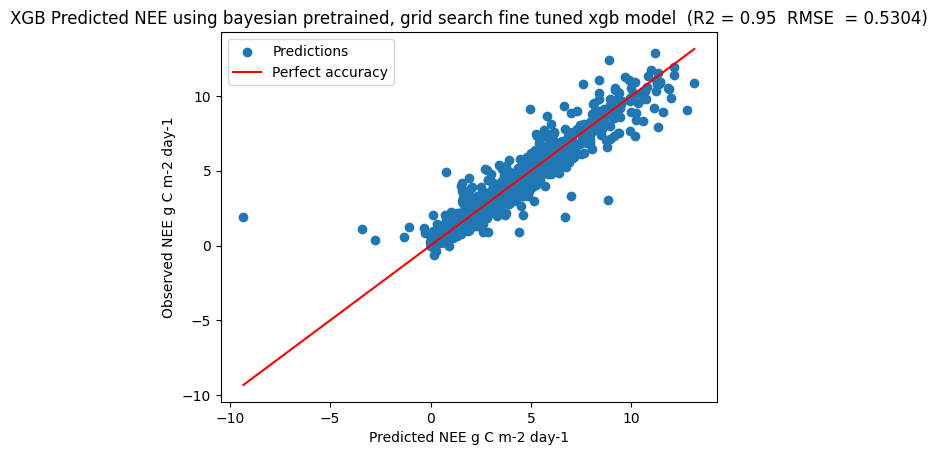

In [33]:
# Calculate R2 score
r2 = R2(y_test, pred)

rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

# Create scatter plot
plt.scatter(y_test, pred)

# Plot a red line for perfect accuracy
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='r')

# Add title and legend
plt.title("XGB Predicted " + target +  " using bayesian pretrained, grid search fine tuned xgb model  (R2 = %0.2f  RMSE  = %0.4f)" %  (r2, rmse))
plt.legend(['Predictions', 'Perfect accuracy'], loc='upper left')
plt.xlabel("Predicted NEE g C m-2 day-1")
plt.ylabel("Observed NEE g C m-2 day-1")

#plt.savefig("results/bayesian pretrained, grid search fine tuned xgb model  " + target + "with planting details.png" )
# Show plot
plt.show()

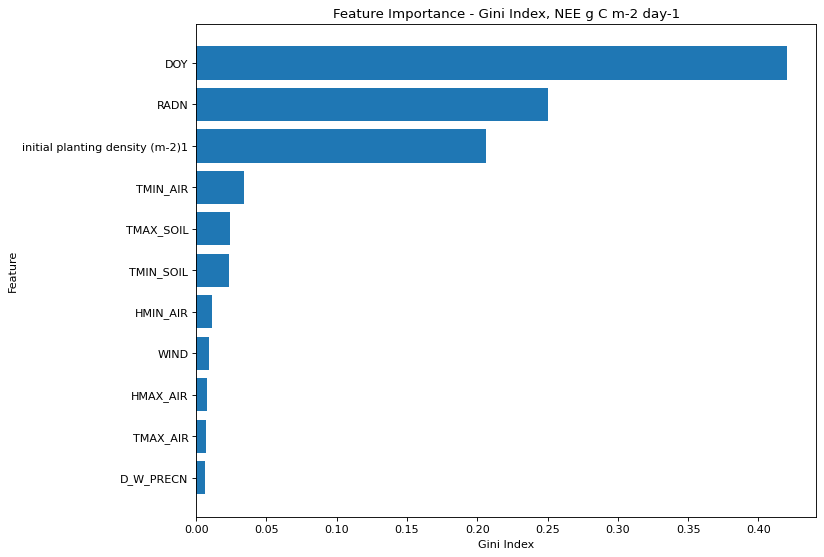

In [34]:
importances = pd.DataFrame({'GINI': xgb_r.feature_importances_}, index=X_train.columns).sort_values(by='GINI', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8), dpi=80)
plt.barh(importances.index, importances['GINI'])

# Add title and axis labels
plt.title('Feature Importance - Gini Index, NEE g C m-2 day-1')
plt.xlabel('Gini Index')
plt.ylabel('Feature')

#plt.savefig('results/FeatureImportanceGB_sim_data_with_ameriflux_pred' + target + "with_planting_details.png")
# Show the plot
plt.show()

In [43]:
xgb_r.save_model('models/xgb_final.json')

In [30]:
g = importances[importances > 0.0001].dropna()

In [18]:
os.makedirs('feature_analysis/xgboost', exist_ok=True)  
g.to_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')  

In [38]:
res = X_test.copy()

res['PRED'] = pred
res['DATE'] = X_test_yrs

In [39]:
res

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY,PRED,DATE
2245,-7.3800,1.507896,-16.170,0.000,5.477040,0.312617,0.156827,0.421100,7.530840,8.2,54,0.243969,2021-02-23
1050,1.9180,8.105000,1.010,0.000,3.396000,0.378945,0.210692,9.933484,186.219000,8.2,320,0.904436,2017-11-16
1479,-0.7215,-717.484262,-16.730,0.100,3.071448,0.466492,0.121660,710.442625,3.557160,6.6,19,0.005938,2019-01-19
1834,12.0900,4.103523,-1.340,0.000,2.140560,0.901451,0.489379,3.560481,4.085117,6.2,9,0.144354,2020-01-09
1452,0.6280,2.545000,-2.068,0.000,2.600000,0.772066,0.384980,4.617258,149.472000,8.2,357,0.814903,2018-12-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620,29.5100,24.461156,15.600,0.000,3.520440,1.723060,1.173564,18.045387,30.503880,8.2,160,1.808704,2019-06-09
2000,19.7560,21.479000,17.018,0.164,3.509000,1.836352,1.062994,19.535314,488.085000,8.2,175,6.697570,2020-06-23
1033,19.4100,18.019639,9.650,0.000,2.593800,1.130368,0.965530,15.345074,11.979740,6.2,303,3.871724,2017-10-30
565,25.4750,22.930000,24.541,0.359,3.119000,2.621017,1.697974,19.715266,470.662000,8.2,201,11.740566,2016-07-19


In [ ]:
res.sort_values(by=['PRED'], ascending=False)

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY,PRED,DATE
932,29.907,23.772000,28.151,0.125,2.550000,2.528056,1.629195,21.031280,469.461,8.2,202,12.897254,2017-07-21
1661,27.599,22.638000,26.651,0.001,3.491000,2.719273,2.192349,21.045011,470.662,8.2,201,12.401471,2019-07-20
569,28.043,24.184000,26.594,0.039,2.677000,1.748616,1.446598,18.905166,465.640,8.2,205,11.922812,2016-07-23
565,25.475,22.930000,24.541,0.359,3.119000,2.621017,1.697974,19.715266,470.662,8.2,201,11.740566,2016-07-19
194,26.685,25.183000,23.746,0.000,1.764000,2.322903,1.612989,19.266414,477.063,8.2,195,11.517154,2015-07-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,7.070,12.244000,5.543,0.003,2.129000,0.700238,0.289689,8.965513,207.759,8.2,310,-0.003521,2015-11-06
1398,0.000,-715.438887,0.000,0.000,2.116368,0.602357,0.322826,712.925328,0.000,6.6,303,-0.024890,2018-10-30
683,9.966,11.335000,6.207,0.000,2.109000,0.773638,0.497606,8.340426,188.191,8.2,319,-0.268727,2016-11-14
1118,-4.146,0.344000,-5.107,0.028,3.051000,0.756718,0.373341,3.303680,179.310,8.2,23,-0.390731,2018-01-23


In [83]:
def get_season_by_date(month: int):
    season_map = {
    1 :'WINTER' ,
    2:'SPRING',
    3:'SUMMER',
    4:'AUTUMN'
    }
    season_index = month %12 // 3 + 1
    
    return season_map[season_index]


def interpret_predictions(feats: pd.Series, nee: float, date: np.datetime64):
    season_nee_means = {
    "AUTUMN": 4.314248,
    "SPRING": 0.696710,
    "SUMMER": 2.887943,
    "WINTER": 1.484983
    }
    
    if (nee > 0):
        print("The agroecosystem is estimated to be a net carbon sink, with a net ecosystem exchange of %0.4f" % nee)
    else:
        print("The agroecosystem is estimated to be a net carbon source, with a net ecosystem exchange of %0.4f" % nee)
    
    
    season = get_season_by_date(date.month)
    
    print("The season is " + season)
    
    print("Average agroecosystem NEE in " + season + " is: " + str(season_nee_means[season]))
    if (nee > season_nee_means[season]):
        print("Your agroecosystem is estimated to have a higher carbon absorbtion capability than an average agroecosystem in " + season)
    else:
        print("Your agroecosystem is estimated to have a lower carbon absorbtion capability than an average agroecosystem in " + season)
    
    
    

interpret_predictions(res['DATE'], res.sort_values(by=['PRED'], ascending=False)['PRED'].iloc[0], res.sort_values(by=['PRED'], ascending=False)['DATE'].iloc[0])
    

The agroecosystem is estimated to be a net carbon sink, with a net ecosystem exchange of 12.8973
The season is SUMMER
Average agroecosystem NEE in SUMMER is: 2.887943
Your agroecosystem is estimated to have a higher carbon absorbtion capability than an average agroecosystem in SUMMER
